In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils import pipeline
import seaborn as sns
import plotly.express as px
import os
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import layers





# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joaof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\joaof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
data = pd.read_csv("qatar_airways_reviews.csv")
data.drop(columns = "Unnamed: 0", inplace = True)

In [3]:
data.head(5)

,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,Aircraft,Verified
0,2024-03-02,1.0,10.0,“marred by inconveniences”,Mary Le,United Kingdom,2024-03-02,The delay of my flight from Haneda to Doha ca...,Solo Leisure,Economy Class,Tokyo to London Heathrow via Doha,March 2024,no,NaN,0.0
1,2024-02-29,1.0,10.0,"""seat wouldn't stay up""",Brian English,Canada,2024-02-29,They convinced me that I needed to pay $1500...,Couple Leisure,Business Class,Doha to Montreal,February 2024,no,NaN,1.0
2,2024-02-29,1.0,10.0,"""no attempt to address our complaint""",Wayne Burgess,Australia,2024-02-29,I have sent 5 emails and have only received ...,Business,Economy Class,Doha to Perth,November 2023,no,A380,1.0
3,2024-02-25,10.0,10.0,“I hope they update the A380”,Alwaleed Althani,Qatar,2024-02-25,We flew on probably the first A380 the airlin...,Couple Leisure,First Class,Doha to London Heathrow,February 2024,NaN,A380-800,1.0
4,2024-02-22,7.0,10.0,"""I’d rate them maybe 7/10""",W Warnock,United Kingdom,2024-02-22,"Service was ok, pretty good on my aisle and ...",Couple Leisure,Business Class,Auckland to Doha,February 2024,no,A350,1.0


# Data Exploration

In [4]:
data.duplicated().sum()

np.int64(1)

In [5]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2368 entries, 0 to 2368
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date Published     2368 non-null   object 
 1   Rating             2367 non-null   float64
 2   Max Rating         2367 non-null   float64
 3   Title              2368 non-null   object 
 4   Author             2368 non-null   object 
 5   Country            2368 non-null   object 
 6   Date               2368 non-null   object 
 7   Review Body        2368 non-null   object 
 8   Type Of Traveller  1934 non-null   object 
 9   Seat Type          2368 non-null   object 
 10  Route              1931 non-null   object 
 11  Date Flown         1925 non-null   object 
 12  Recommended        587 non-null    object 
 13  Aircraft           1281 non-null   object 
 14  Verified           1252 non-null   float64
dtypes: float64(3), object(12)
memory usage: 296.0+ KB


In [7]:
data.describe(include="all")

,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,Aircraft,Verified
count,2368,2367.000000,2367.0,2368,2368,2368,2368,2368,1934,2368,1931,1925,587,1281,1252.000000
unique,1578,NaN,NaN,1784,1980,94,1578,2368,4,4,1380,113,1,371,NaN
top,2015-01-19,NaN,NaN,Qatar Airways customer review,Anders Pedersen,United Kingdom,2015-01-19,MEL-DOH and DOH-MEL. On flight home mobile pho...,Solo Leisure,Economy Class,Bangkok to Doha,October 2015,no,Boeing 777,NaN
freq,10,NaN,NaN,531,51,488,10,1,842,1441,16,37,587,104,NaN
mean,NaN,7.312632,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.920128
std,NaN,2.861161,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.271204
min,NaN,1.000000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,5.000000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,8.000000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,10.000000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [8]:
data["Date Published"].sort_values()

2368    2013-08-05
2365    2013-08-06
2367    2013-08-06
2366    2013-08-06
2364    2013-08-12
           ...    
4       2024-02-22
3       2024-02-25
2       2024-02-29
1       2024-02-29
0       2024-03-02
Name: Date Published, Length: 2368, dtype: object

In [9]:
data["Date"].sort_values()

2368    2013-08-05
2365    2013-08-06
2367    2013-08-06
2366    2013-08-06
2364    2013-08-12
           ...    
4       2024-02-22
3       2024-02-25
2       2024-02-29
1       2024-02-29
0       2024-03-02
Name: Date, Length: 2368, dtype: object

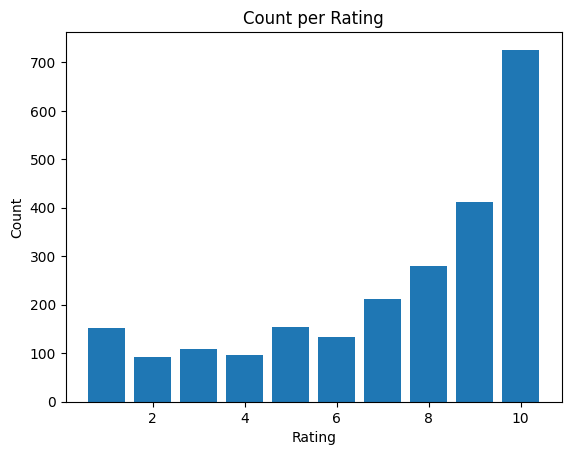

In [10]:
rating_counts = data["Rating"].value_counts()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count per Rating")
plt.show()

In [11]:
data["Title"].sample(12)

1094            "excellent customer service"
1744                  "the flight was great"
1843    "catering is much like a restaurant"
685                  "they got me home safe"
488                  "Overall great service"
843              "if I could check in early"
1977           Qatar Airways customer review
2154           Qatar Airways customer review
2126           Qatar Airways customer review
1809       "great flight with Qatar Airways"
687       "experience was absolutely superb"
2232           Qatar Airways customer review
Name: Title, dtype: object

In [12]:
data[data["Title"] == "Qatar Airways customer review"].count()

Date Published       531
Rating               531
Max Rating           531
Title                531
Author               531
Country              531
Date                 531
Review Body          531
Type Of Traveller     97
Seat Type            531
Route                 96
Date Flown            88
Recommended          116
Aircraft              78
Verified               9
dtype: int64

In [13]:
data["Review Body"].sample(12)

897       Kochi to Houston via Doha. The flight from D...
700       Perth to Vienna via Doha on Qatar A350 aircr...
622       I was due to fly back home to Doha from Ista...
2165    SGN-DOH-NBO on 14 June 2014. Metal was A330-20...
1964    Our route was on March 3 2015 London - Doha - ...
2188    NBO-DOH-BUD on 19 May 2014. All flights on tim...
560       This was not my first experience with Qatar ...
191       I had to travel home in March 2023 and it wa...
2127    MXP-DOH (A320 business): Flew the refurbished ...
938       Auckland to Johannesburg via Doha. On time f...
1204      Berlin to Kuala Lumpur via Doha. The usually...
1707    Edinburgh to Doha. Plenty space, comfortable s...
Name: Review Body, dtype: object

In [14]:
data["number_of characters"] = data["Review Body"].apply(lambda x: len(x))
data["numbers_of_sentences"] = data["Review Body"].apply(lambda x: len(x.split(".")))

In [15]:
data[["number_of characters", "numbers_of_sentences"]].describe()

,number_of characters,numbers_of_sentences
count,2368.000000,2368.000000
mean,736.329392,9.450169
std,486.785865,5.132882
min,98.000000,2.000000
25%,395.750000,6.000000
50%,619.000000,8.000000
75%,930.250000,11.000000
max,3508.000000,49.000000


In [16]:
data["Type Of Traveller"].unique()

array(['Solo Leisure', 'Couple Leisure', 'Business', 'Family Leisure',
       nan], dtype=object)

In [17]:
data["Seat Type"].unique()

array(['Economy Class', 'Business Class', 'First Class',
       'Premium Economy'], dtype=object)

In [18]:
data["Route"].sample(5)

256                       Zurich to Doha
1198                       Doha to Miami
578            Boston to Beirut via Doha
1235                       Doha to Perth
501     Manchester to Cape town via Doha
Name: Route, dtype: object

Conclusions:
- The dataset contains 2369 records, one of them was duplicated so we dropped it from the 2368 remaining all of them have a title and review associated and all but one also have a rating associated, as these are the most relevant columns for our project
- The reviews are from 05 of August of 2013 to 02 of March of 2024 as can be seen in the `Date Published` column
- The `Rating` of the reviews go from 1 to 10 and the average rating is 7.312632 which is high meaning that there could be a tendency to give overly high ratings. The distribution of this column is skewed having more cases of 10 than any other ranting and therefore as the data is unbalanced we shouldn't use Accuracy and use F1 score instead
- `Max Rating` is just a column saying that 10 is the maximum rating possible, this column seems useless as it could be inferred from the `Rating` column
- `Title` is a column containing the title of reviews it is a string containing letters mostly also numbers and -, but not any emojis we could try to combine it with the reviews themselves however the results can also be worse as there are 532 of titles like this: "Qatar Airways customer review" that can confuse our models
- `Author` column has strings with the name of the author
- `Country` has the name of the country where the reviewer lives and the reviews came from 94 countries being the most common the UK
- `Date` column is a copy of the `Date Published` column therefore should be dropped
- `Review Body` column contains the reviews which are strings with normal characters as well as emojis that must be dealt with. The average number of characters in a review is 736	and the average number of sentences is 9. More exploration on this column as well as the `Title` will be done next
- `Type of Traveller` has 4 different types of travelers: 'Solo Leisure', 'Couple Leisure', 'Business', 'Family Leisure'
- There are also 4 types of `Seat Types`: 'Economy Class', 'Business Class', 'First Class', 'Premium Economy'
- The column `Route` contains the departure city and arrival city as well as any the city where they need to change flights if needed
- `Date Flown` contains the date of the flight being reviewed
- `Recommended` contains information if the review was recommended, this column has less than 25% of non missing data and only has 1 value: "no", therefore provides very little information
- `Aircraft` is a string with the name of the plane the reviewer traveled in
- `Verified` has the value 0 if the reviewer isn't verified and the value 1 if the reviewer is verified

# Data Understanding

In [19]:
reviews_only = data.copy()
reviews_only.drop(columns = [n for n in data.columns if n not in ["Review Body", "Rating"]], inplace = True)
reviews_only.dropna(inplace = True)
reviews_only["All_lower"] = reviews_only["Review Body"].apply(lambda x: x.lower())
reviews_only

,Rating,Review Body,All_lower
0,1.0,The delay of my flight from Haneda to Doha ca...,the delay of my flight from haneda to doha ca...
1,1.0,They convinced me that I needed to pay $1500...,they convinced me that i needed to pay $1500...
2,1.0,I have sent 5 emails and have only received ...,i have sent 5 emails and have only received ...
3,10.0,We flew on probably the first A380 the airlin...,we flew on probably the first a380 the airlin...
4,7.0,"Service was ok, pretty good on my aisle and ...","service was ok, pretty good on my aisle and ..."
...,...,...,...
2364,9.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,flew first class cai-doh on qr503 on 8th aug 2...
2365,7.0,I took a flight to London on 17th July with my...,i took a flight to london on 17th july with my...
2366,5.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,mad-doh-dxb and back. boeing 777 in mad-doh se...
2367,7.0,GVA-AUH A320. Good food but after the main mea...,gva-auh a320. good food but after the main mea...


In [20]:
preprocessor = pipeline.MainPipeline() #The pipeline by default removes every unnecessary character and leaves the text not lemmatized

reviews_only["Preprocessed_Reviews"] = reviews_only["Review Body"].apply(lambda x: preprocessor.main_pipeline(x)) 
reviews_only

,Rating,Review Body,All_lower,Preprocessed_Reviews
0,1.0,The delay of my flight from Haneda to Doha ca...,the delay of my flight from haneda to doha ca...,delay flight haneda doha caused bit chaos upon...
1,1.0,They convinced me that I needed to pay $1500...,they convinced me that i needed to pay $1500...,convinced needed pay 1500 add middle name flig...
2,1.0,I have sent 5 emails and have only received ...,i have sent 5 emails and have only received ...,sent 5 email received 2 automatic response ema...
3,10.0,We flew on probably the first A380 the airlin...,we flew on probably the first a380 the airlin...,flew probably first a380 airline received keep...
4,7.0,"Service was ok, pretty good on my aisle and ...","service was ok, pretty good on my aisle and ...",service ok pretty good aisle extremely slow wi...
...,...,...,...,...
2364,9.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,flew first class cai-doh on qr503 on 8th aug 2...,flew first class cai-doh qr503 8th aug 2013 qa...
2365,7.0,I took a flight to London on 17th July with my...,i took a flight to london on 17th july with my...,took flight london 17th july 35 year old son w...
2366,5.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,mad-doh-dxb and back. boeing 777 in mad-doh se...,mad-doh-dxb back boeing 777 mad-doh sector nic...
2367,7.0,GVA-AUH A320. Good food but after the main mea...,gva-auh a320. good food but after the main mea...,gva-auh a320 good food main meal nothing else ...


In [21]:
n = np.random.randint(0,2368)
print(reviews_only.iloc[n]["Review Body"])
print(reviews_only.iloc[n]["All_lower"])
print(reviews_only.iloc[n]["Preprocessed_Reviews"])

✅ Verified Review |  Edinburgh to Muscat via Doha. I used to fly British Airways 3 or 4 times a year between Muscat and Edinburgh but considering the visible decline in both aircraft quality and service now being offered by BA I decided to try Qatar Airways. The difference is night & day! From booking to boarding there is nothing that is too much trouble for Qatar Airways staff. Onboard you will find spotless aircraft, in my case the fabulous A350 between Muscat and Doha and the equally pleasant 787-8 Doha to Edinburgh. You will also experience a crew that are not only efficient but also value you as a passenger. Although I was travelling in Business class both the Muscat - Doha and Doha - Muscat sectors are ticketed in First which allowed me access to the First Class lounge at Doha airport. This far exceeds the lounges offered by BA in both Edinburgh and T5 Heathrow. Both aircraft provided comfortable seating and decent IFE in the "Oryx One" system. Food and beverage service is excell

<font color='#BFD72F' size=4>BOW plot for the reviews</font> <a class="anchor" id="P21"></a>


In [22]:
#Create a BOW and get the number of times each word in the reviews appears
bow_vectorizer = CountVectorizer()
bow_td_matrix = bow_vectorizer.fit_transform(reviews_only["All_lower"]).toarray()
bow_word_list = bow_vectorizer.get_feature_names_out().tolist()
bow_words_freq = pipeline.word_freq_calculator(bow_td_matrix, bow_word_list)
bow_words_freq

,words,frequency
9217,the,16481
964,and,10451
9322,to,10219
9978,was,7651
4821,in,5162
...,...,...
18,0230am,1
16,01h40,1
15,0196,1
14,0161,1


In [23]:
#The same but for a preprocessed version
bow_vectorizer = CountVectorizer()
prepoc_bow_td_matrix = bow_vectorizer.fit_transform(reviews_only["Preprocessed_Reviews"]).toarray()
prepoc_bow_word_list = bow_vectorizer.get_feature_names_out().tolist()
prepoc_bow_words_freq = pipeline.word_freq_calculator(prepoc_bow_td_matrix, prepoc_bow_word_list)
prepoc_bow_words_freq

,words,frequency
3836,flight,4444
3096,doha,3171
6869,qatar,2491
7773,seat,2143
7856,service,2022
...,...,...
30,0509,1
31,0555,1
5,01,1
9715,zya,1


In [24]:
reviews_only["First_BOW"] = bow_td_matrix.tolist()
reviews_only

,Rating,Review Body,All_lower,Preprocessed_Reviews,First_BOW
0,1.0,The delay of my flight from Haneda to Doha ca...,the delay of my flight from haneda to doha ca...,delay flight haneda doha caused bit chaos upon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.0,They convinced me that I needed to pay $1500...,they convinced me that i needed to pay $1500...,convinced needed pay 1500 add middle name flig...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1.0,I have sent 5 emails and have only received ...,i have sent 5 emails and have only received ...,sent 5 email received 2 automatic response ema...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,10.0,We flew on probably the first A380 the airlin...,we flew on probably the first a380 the airlin...,flew probably first a380 airline received keep...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7.0,"Service was ok, pretty good on my aisle and ...","service was ok, pretty good on my aisle and ...",service ok pretty good aisle extremely slow wi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
2364,9.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,flew first class cai-doh on qr503 on 8th aug 2...,flew first class cai-doh qr503 8th aug 2013 qa...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2365,7.0,I took a flight to London on 17th July with my...,i took a flight to london on 17th july with my...,took flight london 17th july 35 year old son w...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2366,5.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,mad-doh-dxb and back. boeing 777 in mad-doh se...,mad-doh-dxb back boeing 777 mad-doh sector nic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2367,7.0,GVA-AUH A320. Good food but after the main mea...,gva-auh a320. good food but after the main mea...,gva-auh a320 good food main meal nothing else ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:
reviews_only["Preprocessed_BOW"] = prepoc_bow_td_matrix.tolist()
reviews_only

,Rating,Review Body,All_lower,Preprocessed_Reviews,First_BOW,Preprocessed_BOW
0,1.0,The delay of my flight from Haneda to Doha ca...,the delay of my flight from haneda to doha ca...,delay flight haneda doha caused bit chaos upon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.0,They convinced me that I needed to pay $1500...,they convinced me that i needed to pay $1500...,convinced needed pay 1500 add middle name flig...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1.0,I have sent 5 emails and have only received ...,i have sent 5 emails and have only received ...,sent 5 email received 2 automatic response ema...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,10.0,We flew on probably the first A380 the airlin...,we flew on probably the first a380 the airlin...,flew probably first a380 airline received keep...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7.0,"Service was ok, pretty good on my aisle and ...","service was ok, pretty good on my aisle and ...",service ok pretty good aisle extremely slow wi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
2364,9.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,flew first class cai-doh on qr503 on 8th aug 2...,flew first class cai-doh qr503 8th aug 2013 qa...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2365,7.0,I took a flight to London on 17th July with my...,i took a flight to london on 17th july with my...,took flight london 17th july 35 year old son w...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2366,5.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,mad-doh-dxb and back. boeing 777 in mad-doh se...,mad-doh-dxb back boeing 777 mad-doh sector nic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2367,7.0,GVA-AUH A320. Good food but after the main mea...,gva-auh a320. good food but after the main mea...,gva-auh a320 good food main meal nothing else ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
def plot_term_frequency(df, name, nr_terms, df_name, show=True):
    # Ensure seaborn and matplotlib are configured for high quality
    sns.set_theme(style="whitegrid", rc={"figure.dpi": 300})
    
    # Create the Seaborn bar plot
    plt.figure(figsize=(12, 10))  # Adjusted size for clarity
    sns_plot = sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    
    # Add a title and axis labels
    plt.title('Top {} Term Frequencies of {}'.format(nr_terms, df_name), fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Display or save the plot
    if show:
        plt.show()
    
    # Save the plot in a high-quality format
    fig = sns_plot.get_figure()
    fig.savefig(f'graphs/Initial_Visualizations/{name}.png', dpi=600, bbox_inches='tight')  # High DPI for better quality
    fig.savefig(f'graphs/Initial_Visualizations/{name}.svg', bbox_inches='tight')  # Vectorized format
    plt.close(fig)  # Clear figure context to avoid overlaps
    
    return fig


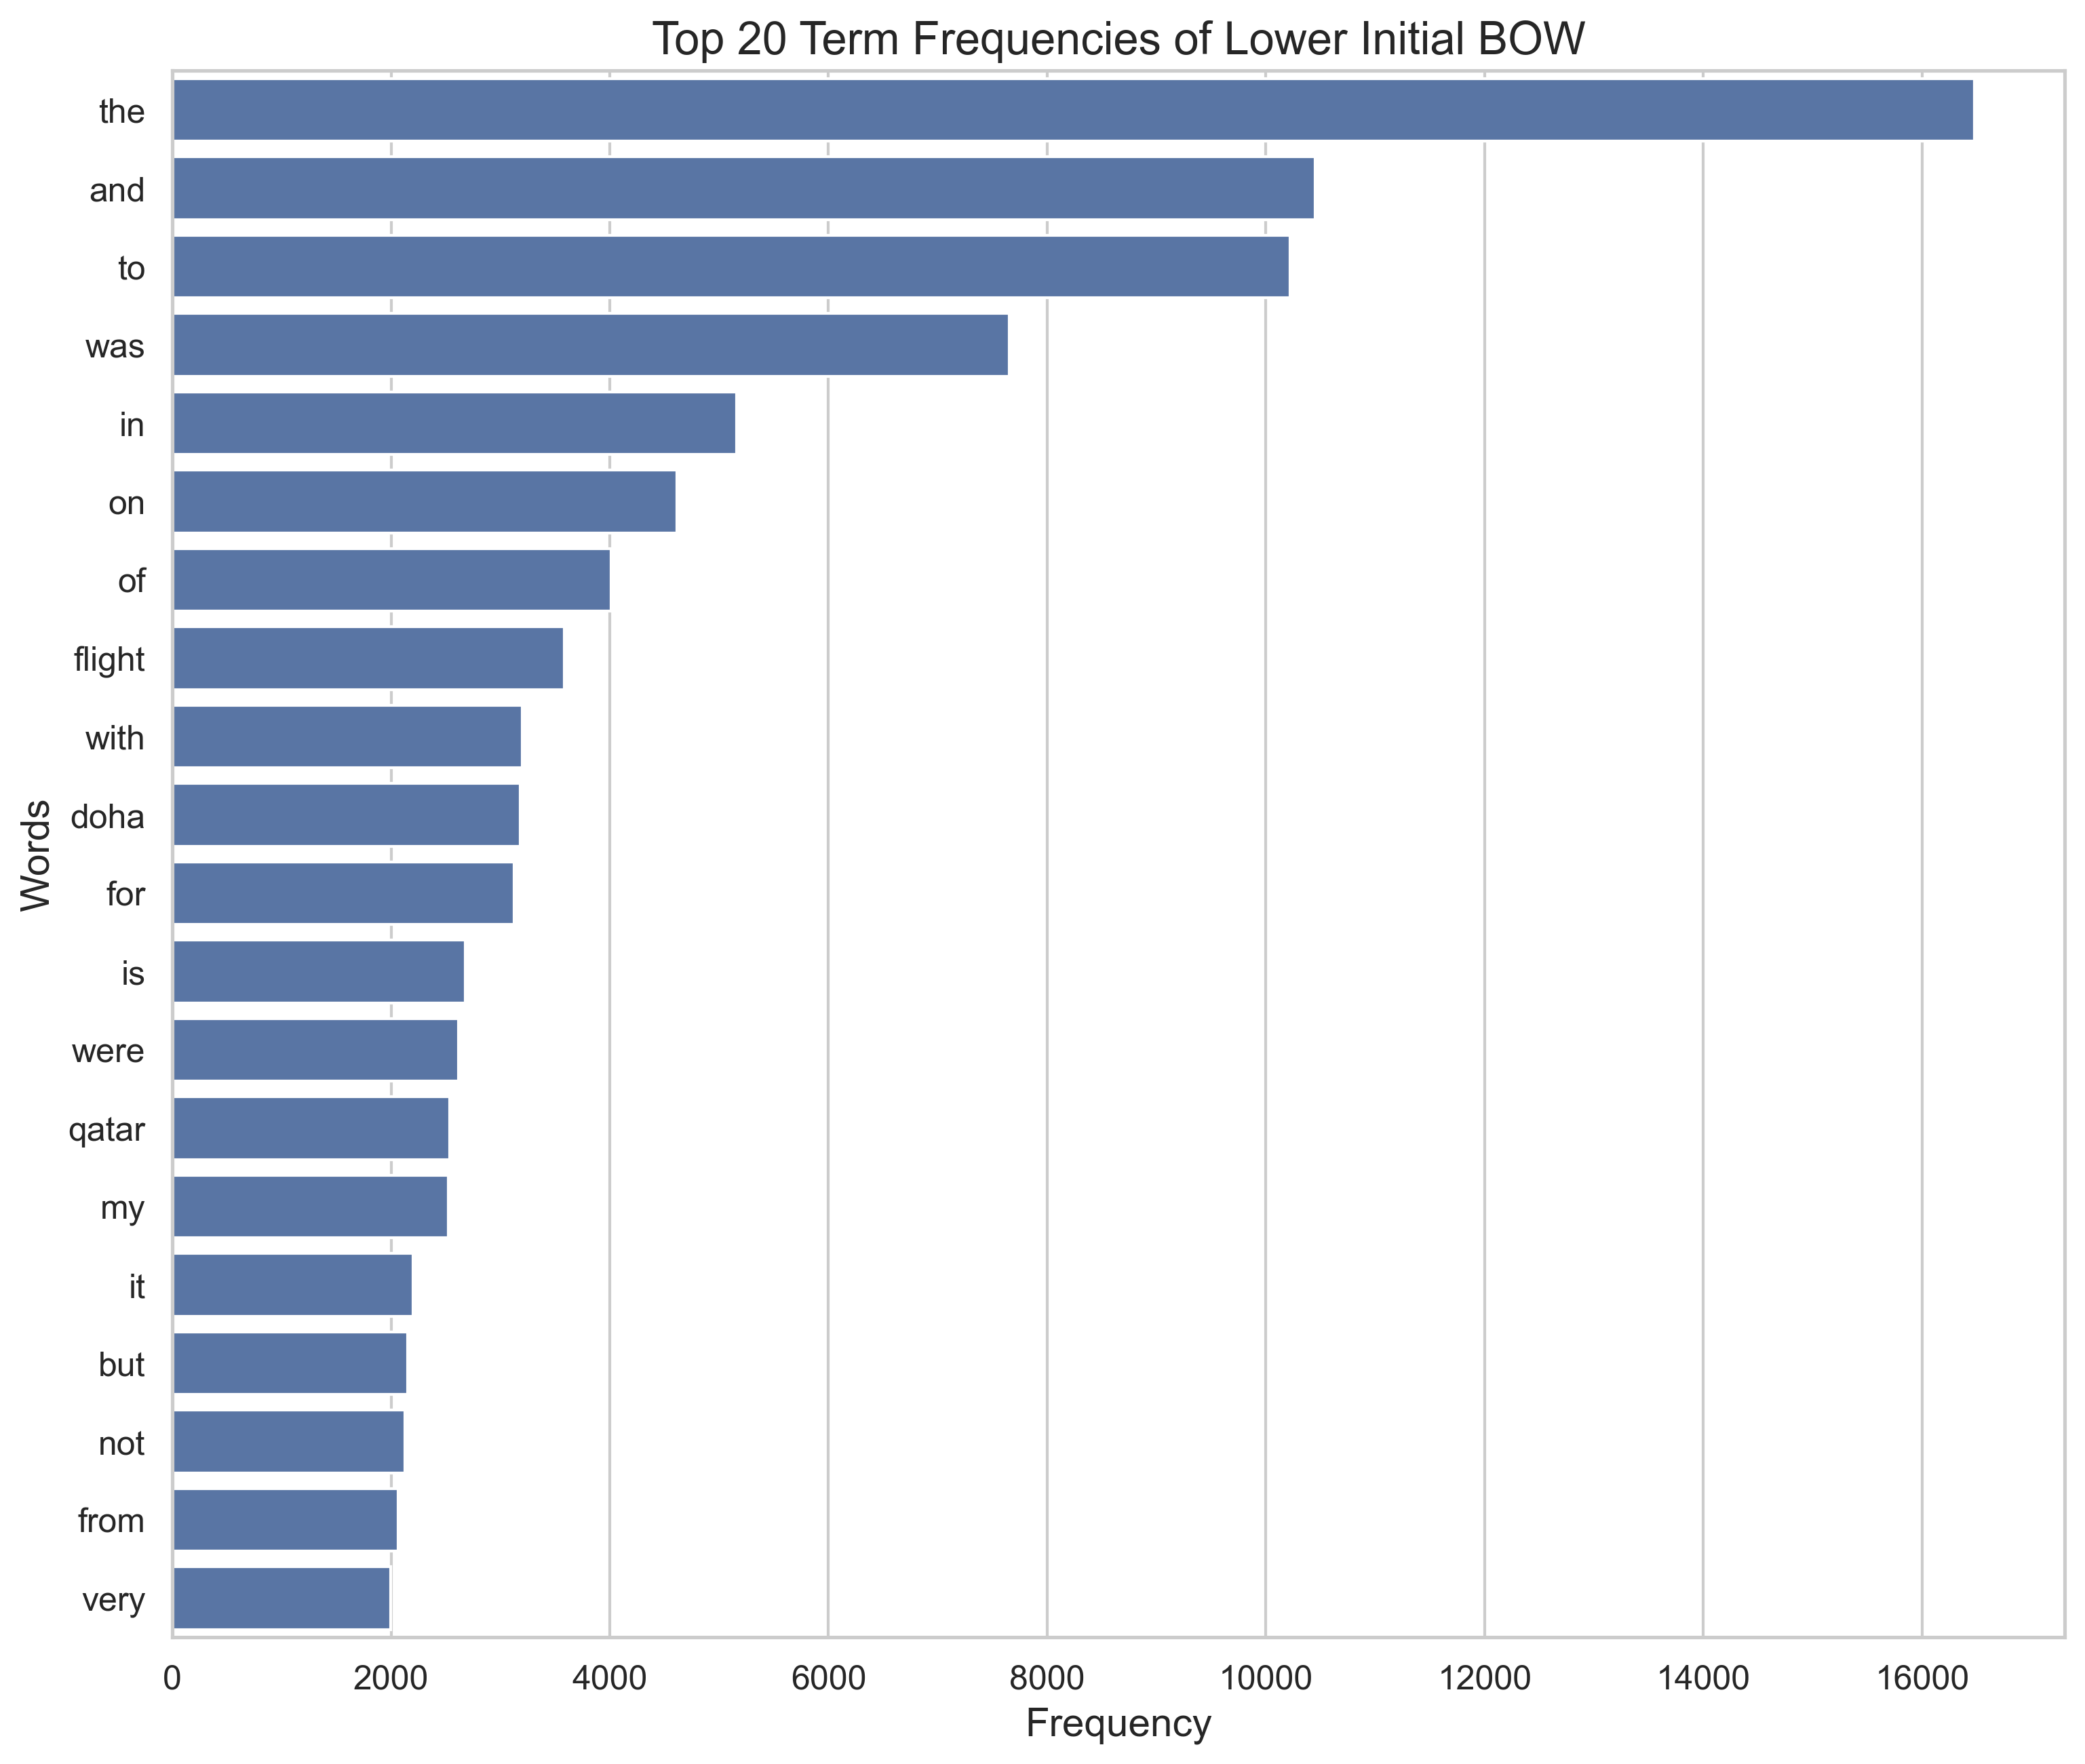

In [29]:
graph_freq = plot_term_frequency(bow_words_freq, name = "20_most_commun_words_initial", nr_terms=20, df_name = "Lower Initial BOW", show = True)

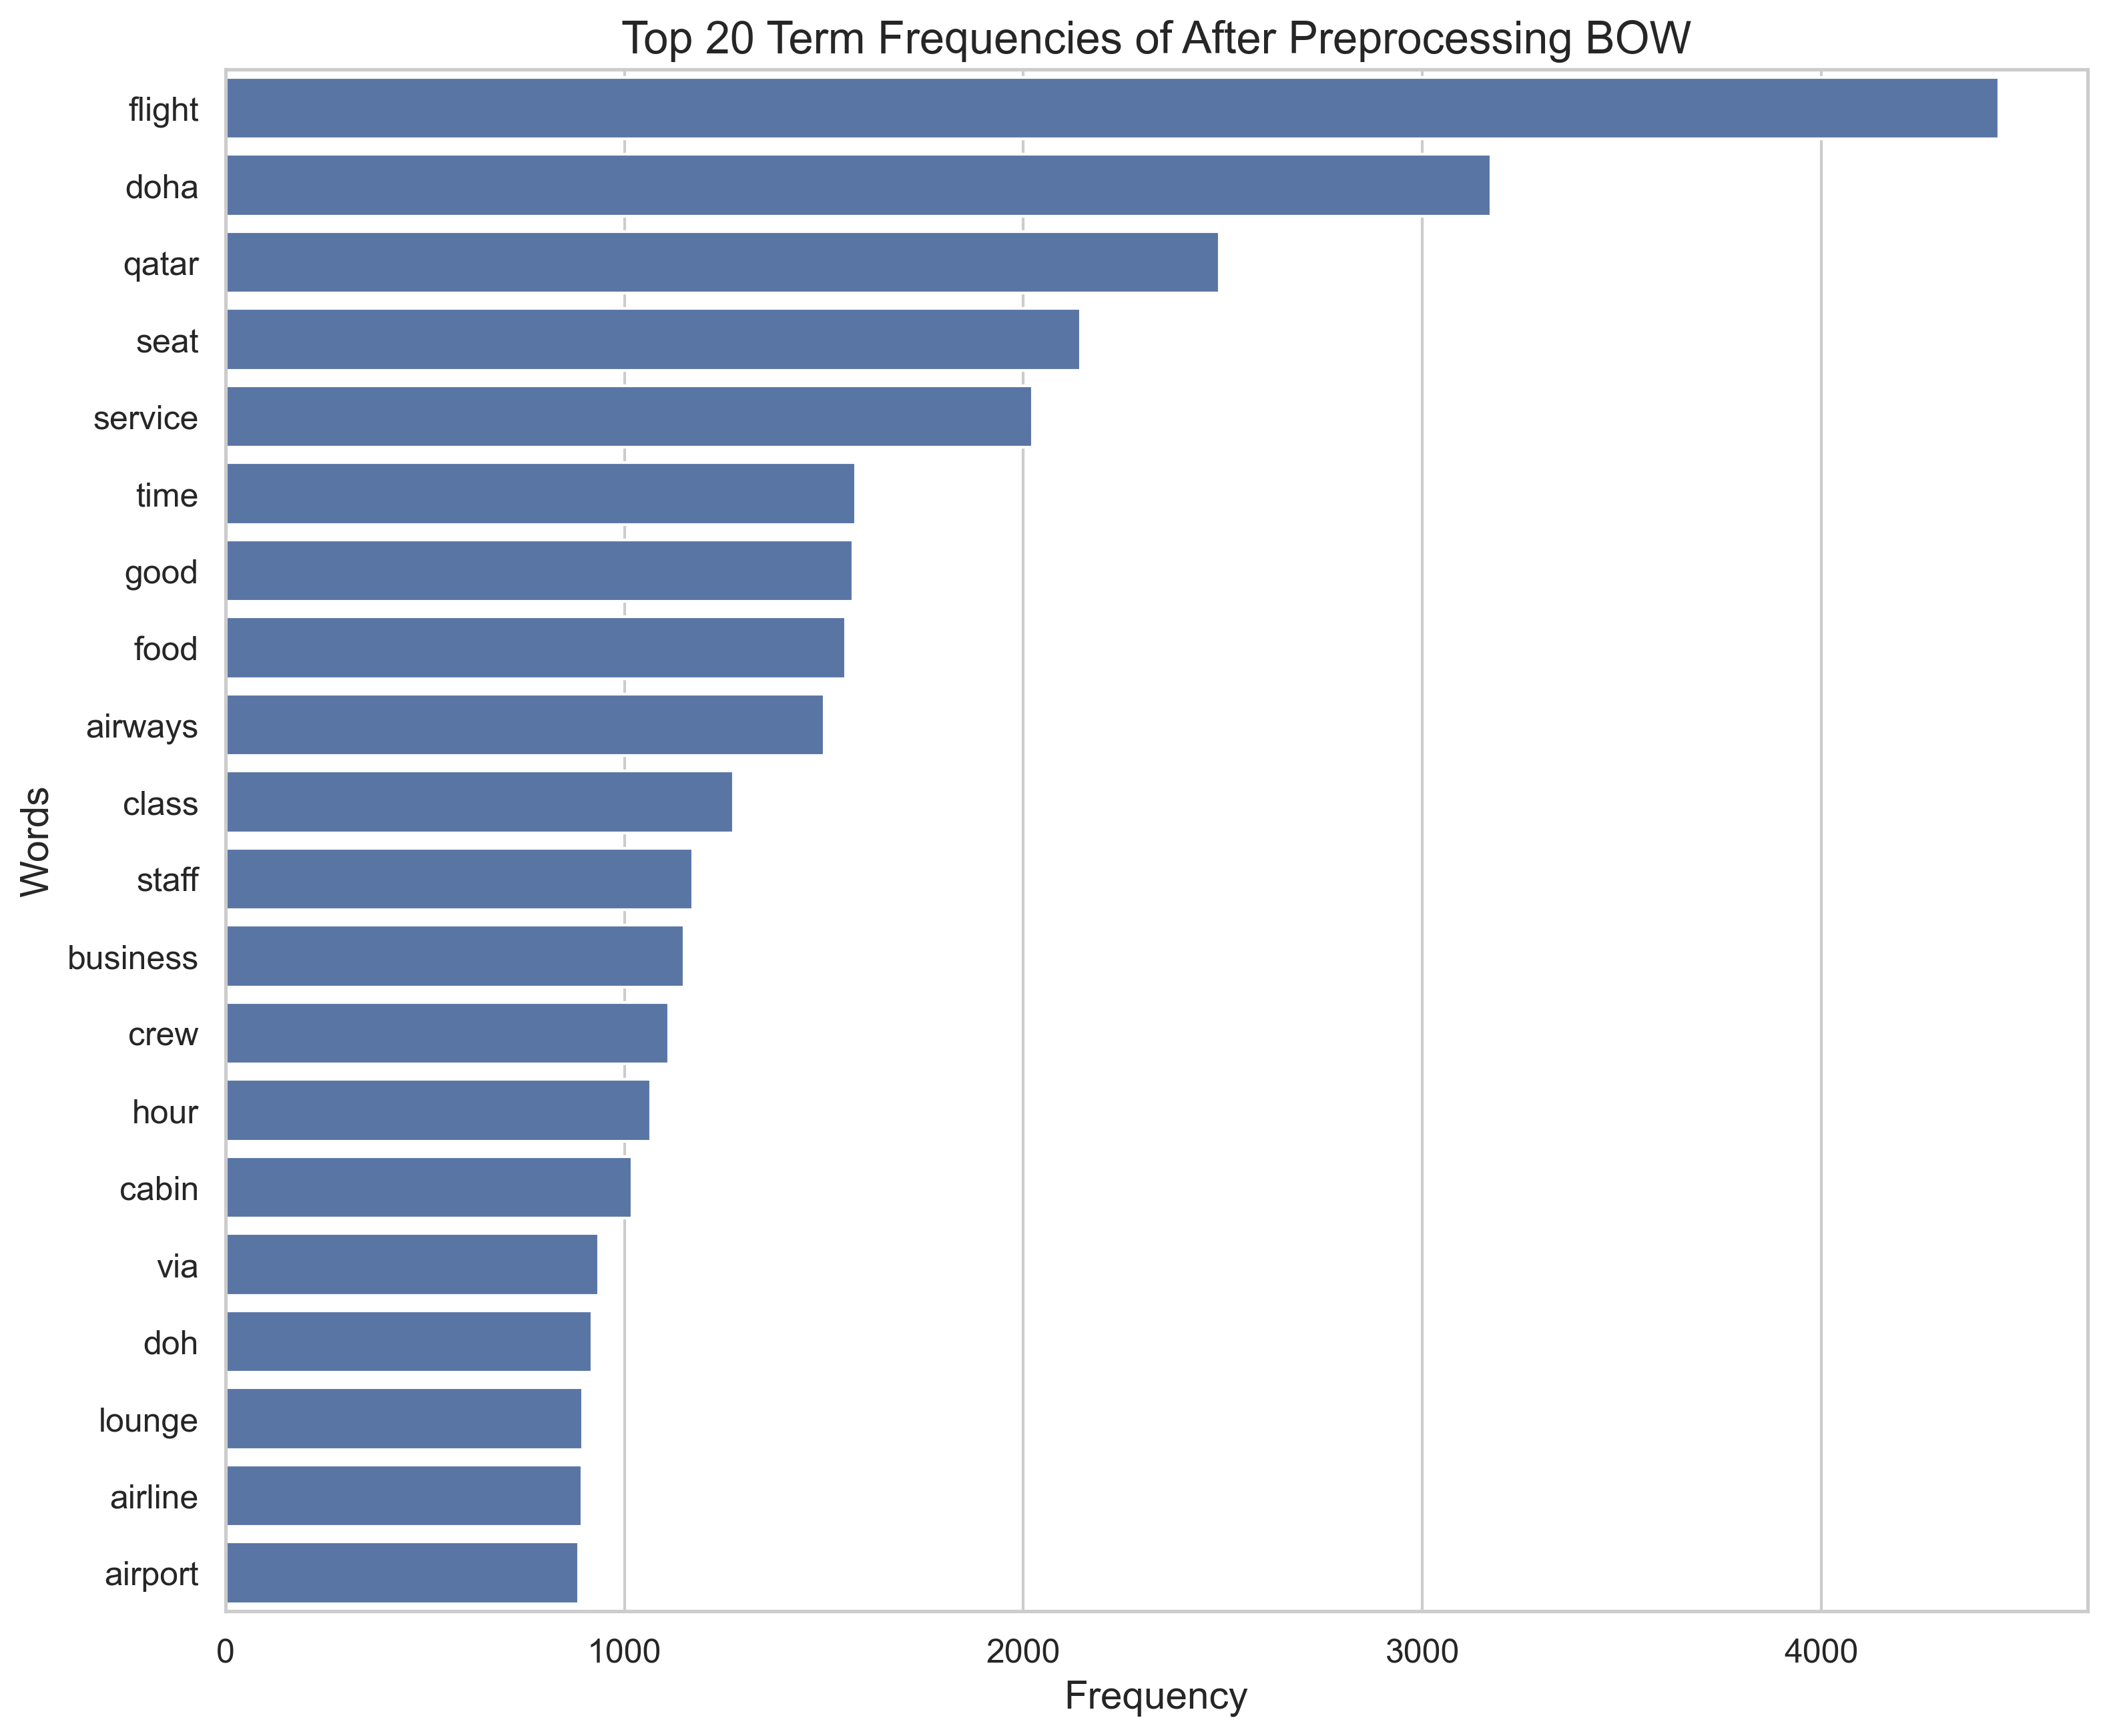

In [30]:
graph_freq = plot_term_frequency(prepoc_bow_words_freq, name = "20_most_commun_words_after_prepocessing", nr_terms=20, df_name = "After Preprocessing BOW", show = True)

<font color='#BFD72F' size=4>Word cloud of reviews</font> <a class="anchor" id="P22"></a>

In [31]:
def word_cloud_generator(folder_path, wc):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    ##Bow visualization
    chapter_bow_df = pipeline.word_freq_calculator(bow_td_matrix, bow_word_list, df_output=False)
    wc.generate_from_frequencies(chapter_bow_df)
    wc.to_file(os.path.join(folder_path, "First_BOW.png"))

In [32]:
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))
word_cloud_generator("graphs/Initial_visualizations", wc)

In [33]:
def prepoc_word_cloud_generator(folder_path, wc):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    ##Bow visualization
    chapter_bow_df = pipeline.word_freq_calculator(prepoc_bow_td_matrix, prepoc_bow_word_list, df_output=False)
    wc.generate_from_frequencies(chapter_bow_df)
    wc.to_file(os.path.join(folder_path, "After_Prepocessing.png"))

In [34]:
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))
prepoc_word_cloud_generator("graphs/Initial_visualizations", wc)

<font color='#BFD72F' size=4>BOW treemap for the reviews</font> <a class="anchor" id="P23"></a>

In [35]:
def get_pos_tag(word):
    tag = nltk.tag.pos_tag([word])[0][1]
    return tag

In [ ]:
bow_words_freq["pos_tag"] = bow_words_freq["words"].apply(get_pos_tag)

#create a tree map
fig = px.treemap(bow_words_freq[:350], 
                path=[px.Constant('Reviews'), 'pos_tag','words'], 
                values='frequency',
                color='frequency',
                color_continuous_scale='viridis',
                )

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [37]:
prepoc_bow_words_freq["pos_tag"] = prepoc_bow_words_freq["words"].apply(get_pos_tag)

#create a tree map
fig = px.treemap(prepoc_bow_words_freq[:350], 
                path=[px.Constant('Reviews'), 'pos_tag','words'], 
                values='frequency',
                color='frequency',
                color_continuous_scale='viridis',
                )

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# Preprocessing and preparation to modeling

In the following part we will try to predict the rating taking into consideration only the reviews.

In [27]:
def simplify_rating(rating):
    if rating <= 4:
        return 'negative'
    elif rating <= 7:
        return 'neutral'
    else:
        return 'positive'

reviews_only['Sentiment'] = reviews_only['Rating'].apply(simplify_rating)

reviews_only

,Rating,Review Body,All_lower,Preprocessed_Reviews,First_BOW,Preprocessed_BOW,Sentiment
0,1.0,The delay of my flight from Haneda to Doha ca...,the delay of my flight from haneda to doha ca...,delay flight haneda doha caused bit chaos upon...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative
1,1.0,They convinced me that I needed to pay $1500...,they convinced me that i needed to pay $1500...,convinced needed pay 1500 add middle name flig...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative
2,1.0,I have sent 5 emails and have only received ...,i have sent 5 emails and have only received ...,sent 5 email received 2 automatic response ema...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative
3,10.0,We flew on probably the first A380 the airlin...,we flew on probably the first a380 the airlin...,flew probably first a380 airline received keep...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",positive
4,7.0,"Service was ok, pretty good on my aisle and ...","service was ok, pretty good on my aisle and ...",service ok pretty good aisle extremely slow wi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
...,...,...,...,...,...,...,...
2364,9.0,Flew first class CAI-DOH on QR503 on 8th Aug 2...,flew first class cai-doh on qr503 on 8th aug 2...,flew first class cai-doh qr503 8th aug 2013 qa...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",positive
2365,7.0,I took a flight to London on 17th July with my...,i took a flight to london on 17th july with my...,took flight london 17th july 35 year old son w...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
2366,5.0,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,mad-doh-dxb and back. boeing 777 in mad-doh se...,mad-doh-dxb back boeing 777 mad-doh sector nic...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
2367,7.0,GVA-AUH A320. Good food but after the main mea...,gva-auh a320. good food but after the main mea...,gva-auh a320 good food main meal nothing else ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral


In [28]:
X = reviews_only["Preprocessed_Reviews"]
y = reviews_only["Sentiment"]


In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 144,stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 144, stratify=y_train)

In [30]:
x_train

305     online wi-fi entertainment system limited old ...
902     pleasure fly airline state unequivocally qatar...
1164    ahmedabad chicago via doha everything starting...
1146    traveled colombo philadelphia via doha food ex...
1039    kolkata doha smooth comfortable late late nigh...
                              ...                        
1792    heathrow abu dhabi via doha economy qatar airw...
269     journey started rather bad note air canada map...
2213    lhr-pvg via doha pek-lhr via doha flight cheap...
884     regret choosing qatar airways almost everythin...
1543    flew manchester goa via doha easy check lounge...
Name: Preprocessed_Reviews, Length: 1514, dtype: object

In [31]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

y_train

array([1, 2, 2, ..., 2, 2, 2])

In [32]:
y_train_dec = encoder.inverse_transform(y_train)
y_test_dec = encoder.inverse_transform(y_test)
y_val_dec = encoder.inverse_transform(y_val)

In [33]:
y_train_dec

array(['neutral', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

Negative = 0

Neutral = 1 

Positive = 2

In [34]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
X_val_tfidf = tfidf_vectorizer.transform(x_val)
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [35]:
# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Model:\n")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return model

# Logistic regression - basic model

Logistic Regression Model:

              precision    recall  f1-score   support

           0       0.71      0.33      0.45        72
           1       0.25      0.03      0.05        80
           2       0.66      0.98      0.79       227

    accuracy                           0.66       379
   macro avg       0.54      0.45      0.43       379
weighted avg       0.58      0.66      0.57       379



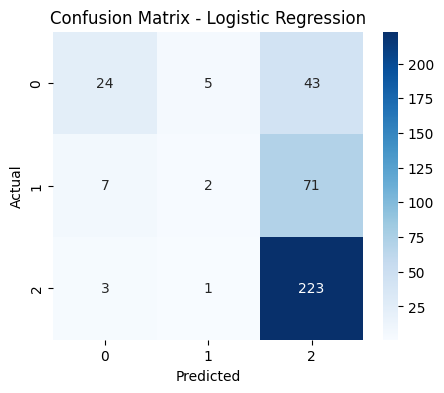

In [36]:
lr_model = evaluate_model(LogisticRegression(random_state=1), X_train_tfidf, X_val_tfidf, y_train, y_val, "Logistic Regression")

Weighted F1: 0.57, very good at predicting positive reviews, weak in predicting the others

# Multinomial Naive Bayes - basic model

Naive Bayes Model:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.00      0.00      0.00        80
           2       0.60      1.00      0.75       227

    accuracy                           0.60       379
   macro avg       0.20      0.33      0.25       379
weighted avg       0.36      0.60      0.45       379



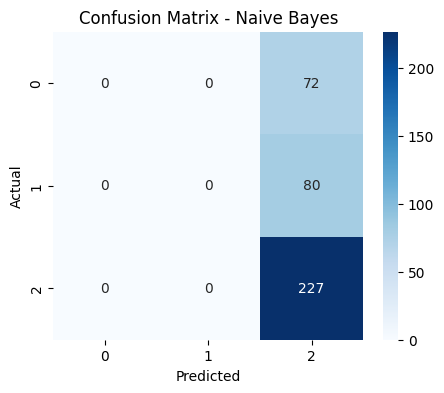

In [ ]:
nb_model = evaluate_model(MultinomialNB(), X_train_tfidf, X_val_tfidf, y_train, y_val, "Naive Bayes")

Weighted F1 score: 0.47. Very weak model predits everything as positive

# Random Forest Classifier - basic model

Random Forest Model:

              precision    recall  f1-score   support

           0       0.67      0.22      0.33        72
           1       0.00      0.00      0.00        80
           2       0.63      0.99      0.77       227

    accuracy                           0.63       379
   macro avg       0.43      0.40      0.37       379
weighted avg       0.51      0.63      0.53       379



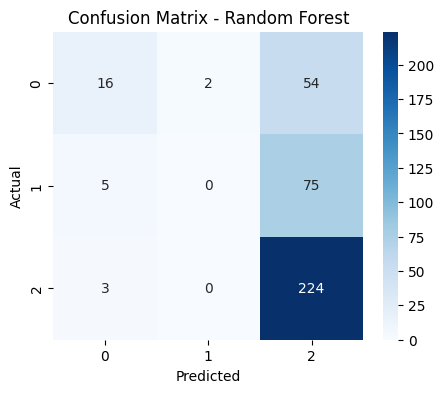

In [37]:
rf_model = evaluate_model(RandomForestClassifier(random_state=1), X_train_tfidf, X_val_tfidf, y_train, y_val, "Random Forest")

Weighted F1 score: 0.53. Fails completely to predict neutral reviews

# SVC - basic model

SVC Model:

              precision    recall  f1-score   support

           0       0.81      0.18      0.30        72
           1       0.00      0.00      0.00        80
           2       0.62      1.00      0.77       227

    accuracy                           0.63       379
   macro avg       0.48      0.39      0.35       379
weighted avg       0.53      0.63      0.51       379



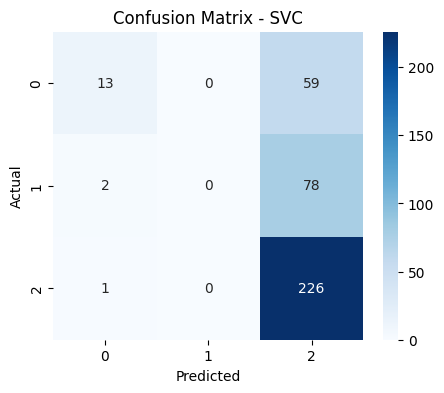

In [38]:
svc_model = evaluate_model(SVC(random_state=1), X_train_tfidf, X_val_tfidf, y_train, y_val, "SVC")

Weighted F1 score: 0.51. Fails completely to predict neutral reviews

### Conclusions after basic models:

- All results are pretty weak as expected as there was no hyperparameter optimization
- There are three models that have a close weighted f1 score we will do hyperparameter optimization for those
- We will drop the Multinomial Naive Bayes as it performed much worse than the others
- So SVM, Logistic Regression and Random Forest will move forward

# Logistic Regression - Hyperparameter Optimization

In [41]:
# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers supporting different penalties
    'max_iter': [100, 500, 1000],  # Number of iterations
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

log_reg = LogisticRegression(random_state=1)

# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted', n_jobs=5, verbose=1)
best_model = grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Logistic Regression Model:

              precision    recall  f1-score   support

           0       0.68      0.56      0.61        72
           1       0.47      0.46      0.47        80
           2       0.82      0.88      0.85       227

    accuracy                           0.73       379
   macro avg       0.66      0.63      0.64       379
weighted avg       0.72      0.73      0.72       379



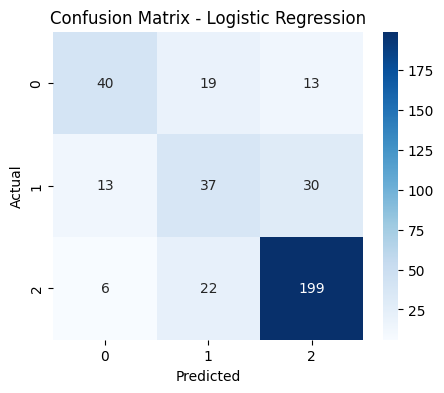

LogisticRegression(C=1, class_weight='balanced', random_state=1)

In [42]:
# Evaluate the best model
evaluate_model(best_model.best_estimator_, X_train_tfidf, X_val_tfidf, y_train, y_val, "Logistic Regression")

Weighted f1 score: 0.72. Much better result after the hyperparameter optimization with now the model being able to predict the correct class much more frequent

# Random Forest - Hyperparameter Optimization

In [45]:
# hyperparameter grid search
param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20],  # Control complexity
    'min_samples_split': [2, 5],  # Reduce the search space
    'min_samples_leaf': [1, 2],  # Small leaves work better for text data
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False], 
    'class_weight': [None, 'balanced']  
}

rf_model = RandomForestClassifier(random_state=1)

# Perform GridSearchCV with weighted F1 score
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
best_model = grid_search.fit(X_train_tfidf, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Model:

              precision    recall  f1-score   support

           0       0.66      0.51      0.58        72
           1       0.42      0.10      0.16        80
           2       0.71      0.95      0.81       227

    accuracy                           0.69       379
   macro avg       0.60      0.52      0.52       379
weighted avg       0.64      0.69      0.63       379



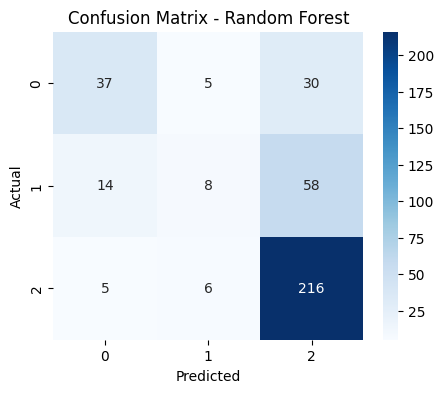

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       random_state=1)

In [46]:
# Evaluate the best model
evaluate_model(best_model.best_estimator_, X_train_tfidf, X_val_tfidf, y_train, y_val, "Random Forest")

Weighted f1 score: 0.63. A way worse result than the Logistic Regression

# SVC - Hyperparameter Optimization

In [47]:
# hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], 
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': [None, 'balanced'],  # Handle class imbalance
    'tol': [1e-4, 1e-3, 1e-2]  # Convergence tolerance
}

# Create the SVC model
svc_model = SVC(random_state=1)

# Perform GridSearchCV with weighted F1 score
grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
best_model = grid_search.fit(X_train_tfidf, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid', 'tol': 0.0001}


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid', 'tol': 0.0001}

SVC Model:

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        72
           1       0.43      0.51      0.47        80
           2       0.85      0.85      0.85       227

    accuracy                           0.72       379
   macro avg       0.65      0.62      0.63       379
weighted avg       0.72      0.72      0.72       379



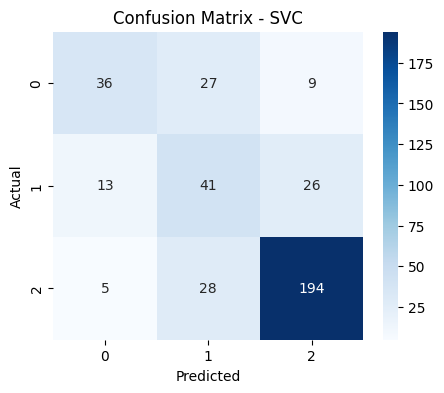

SVC(C=1, class_weight='balanced', kernel='sigmoid', random_state=1, tol=0.0001)

In [48]:
# Evaluate the best model
evaluate_model(best_model.best_estimator_, X_train_tfidf, X_val_tfidf, y_train, y_val, "SVC")

Weighted f1 score: 0.72. Tied in scoring with the logistic regression if it was to choose between the two right now, the better would be the Logistic regression as it is a less complex algorithm

# Neural Network - Basic Model

In [36]:
# Convert integer labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [37]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [39]:
# Get input size from TF-IDF features
input_dim = X_train_tfidf.shape[1]  # TF-IDF produces (samples, features)

# Define a dense neural network for text classification
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(input_dim,), kernel_regularizer = l2(0.0001)))
model.add(Dropout(0.3))
#model.add(Dense(24, activation='relu'))

model.add(Dense(3, activation='softmax'))  # Multiclass classification
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tfidf, y_train_encoded, epochs=20, validation_data = (X_val_tfidf, y_val_encoded), batch_size=64, callbacks = [early_stop, reduce_lr])

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5421 - loss: 1.0800 - val_accuracy: 0.5989 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6036 - loss: 0.9514 - val_accuracy: 0.5989 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6101 - loss: 0.8308 - val_accuracy: 0.5989 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6651 - loss: 0.7171 - val_accuracy: 0.6042 - val_loss: 0.8443 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8463 - loss: 0.6165 - val_accuracy: 0.6095 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9287 - loss: 0.5195 - val_accuracy: 0.6306 - val_loss: 0.7971 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9616 - loss: 0.4294 - val_acc

In [40]:
y_val_predicted= model.predict(X_val_tfidf)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [41]:
# Convert one-hot encoded predictions back to class labels
y_val_predicted_classes = np.argmax(y_val_predicted, axis=1)
y_val_true_classes = np.argmax(y_val_encoded, axis=1)

# Now, you can use classification_report
print(classification_report(y_val_true_classes, y_val_predicted_classes))

              precision    recall  f1-score   support

           0       0.69      0.31      0.42        72
           1       0.35      0.16      0.22        80
           2       0.72      0.98      0.83       227

    accuracy                           0.68       379
   macro avg       0.58      0.48      0.49       379
weighted avg       0.63      0.68      0.62       379



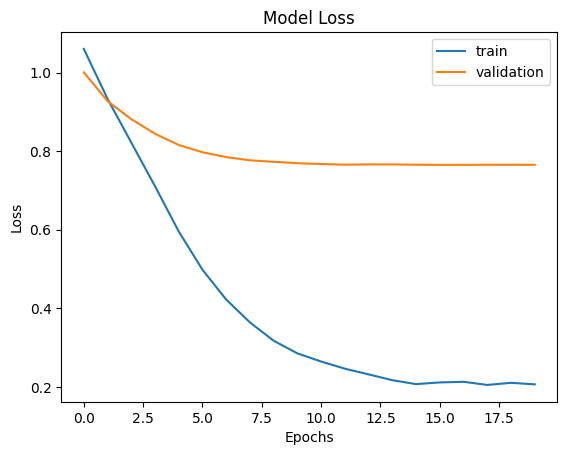

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

For our baseline model it appears that it is suffering from a huge overfit, however the weighted f1 score is 0.62 the biggest between all baselines so the model shows potential

# Neural Network - Hyperparameter Tunning

In [43]:
def nn_improved(hp):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    model = keras.Sequential()

    # Add dense layers with progressively fewer units
    num_layers = hp.Int("num_layers", min_value=1, max_value=4)
    units = 400
    for i in range(1, num_layers + 1):
        units = hp.Int(f'number_of_units_{i}', min_value=32, max_value=units, step=32)
        
        model.add(Dense(units=units, activation="relu", kernel_regularizer=l2(hp.Choice("dense_l2_strength", [0.0, 0.1, 0.01, 0.001, 0.0001]))))
        model.add(BatchNormalization())
        
        # Choose activation function: LeakyReLU or Swish
        activation_choice = hp.Choice("activation", values=["swish", "leaky_relu", "relu"])
        if activation_choice == "swish":
            model.add(tf.keras.layers.Activation('swish'))
        elif activation_choice == "leaky_relu":
            model.add(LeakyReLU(alpha=0.2))  # Default slope of 0.2 for LeakyReLU
        else:
            model.add(tf.keras.layers.Activation('relu'))
        
        model.add(Dropout(hp.Float(f"dense_dropout_{i}", 0.0, 0.6, step=0.1)))

    model.add(Dense(units=3, activation="softmax"))
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3, 1e-4, 1e-5])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model


In [55]:
def nn_improved(hp):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    model = keras.Sequential()

    # Add dense layers with progressively fewer units
    num_layers = hp.Int("num_layers", min_value=1, max_value=3)  # Reduced number of layers
    units = 128  # Reduced units to avoid overfitting
    for i in range(1, num_layers + 1):
        units = hp.Int(f'number_of_units_{i}', min_value=32, max_value=units, step=32)
        
        model.add(Dense(units=units, activation="relu", kernel_regularizer=l2(hp.Choice("dense_l2_strength", [0.0, 0.01, 0.001]))))
        model.add(BatchNormalization())
        
        # Choose activation function: LeakyReLU or Swish
        activation_choice = hp.Choice("activation", values=["swish", "leaky_relu", "relu"])
        if activation_choice == "swish":
            model.add(tf.keras.layers.Activation('swish'))
        elif activation_choice == "leaky_relu":
            model.add(LeakyReLU(alpha=0.2))  # Default slope of 0.2 for LeakyReLU
        else:
            model.add(tf.keras.layers.Activation('relu'))
        
        model.add(Dropout(hp.Float(f"dense_dropout_{i}", 0.2, 0.6, step=0.1)))  # Increased dropout rate

    model.add(Dense(units=3, activation="softmax"))  # 3 output units for 3 classes
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    # Choose optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model


In [56]:
tuner = kt.Hyperband(nn_improved, # the hypermodel
                    objective='val_loss',  # Our main monitoring metric
                    max_epochs=40,
                    factor=2, 
                    directory='tuner_outputs',
                    project_name='nn_tuner_version2')

Reloading Tuner from tuner_outputs\nn_tuner_version2\tuner0.json


In [57]:
tuner.search(X_train_tfidf,
            y_train_encoded,
            epochs = 30,
            validation_data = (X_val_tfidf, y_val_encoded),
            batch_size = 64,
            callbacks=[reduce_lr, early_stop] ,
            )

In [58]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'num_layers': 1, 'number_of_units_1': 128, 'dense_l2_strength': 0.0, 'activation': 'leaky_relu', 'dense_dropout_1': 0.2, 'learning_rate': 0.0001, 'optimizer': 'adam', 'number_of_units_2': 96, 'dense_dropout_2': 0.30000000000000004, 'number_of_units_3': 32, 'dense_dropout_3': 0.4, 'tuner/epochs': 40, 'tuner/initial_epoch': 20, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0160'}


In [59]:
# Compute class weights
y_train_classes = np.argmax(y_train_encoded, axis=1)  # Convert one-hot to class indices
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [61]:
# Model evaluation and visualization
best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(X_train_tfidf,
                        y_train_encoded,
                        epochs = 40,
                        validation_data = (X_val_tfidf, y_val_encoded),
                        batch_size = 32,
                        class_weight = class_weight_dict,
                        callbacks=[reduce_lr, early_stop]
                        )

Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.3594 - loss: 1.0772 - val_accuracy: 0.6755 - val_loss: 1.0870 - learning_rate: 1.0000e-04
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9482 - loss: 0.6745 - val_accuracy: 0.6966 - val_loss: 1.0631 - learning_rate: 1.0000e-04
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9931 - loss: 0.3682 - val_accuracy: 0.7098 - val_loss: 1.0377 - learning_rate: 1.0000e-04
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9987 - loss: 0.2098 - val_accuracy: 0.7071 - val_loss: 1.0076 - learning_rate: 1.0000e-04
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 1.0000 - loss: 0.1302 - val_accuracy: 0.7230 - val_loss: 0.9764 - learning_rate: 1.0000e-04
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 - loss: 0.0883 - val_accuracy: 0.7282 - val_loss: 0.9417 - learning_rate: 1.0000e-04
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 

In [62]:
y_val_predicted2= best_model.predict(X_val_tfidf)
y_val_predicted2= np.argmax(y_val_predicted2, axis = 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [63]:
# Convert one-hot encoded predictions back to class labels
y_val_true_classes = np.argmax(y_val_encoded, axis=1)

# Now, you can use classification_report
print(classification_report(y_val_true_classes, y_val_predicted2))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        72
           1       0.47      0.51      0.49        80
           2       0.85      0.85      0.85       227

    accuracy                           0.72       379
   macro avg       0.63      0.63      0.63       379
weighted avg       0.72      0.72      0.72       379



Weighted f1 score: 0.72. A lot of overfit but overall still better results than the other models, but not a very good model as the overfit is huge

So far Dense Neural Network is the best model as we consider the tradoff of the overfit acceptable (as it still is performing good on unseen data, the validation data) when comparing the results of this model compared to the others

# LSTM

In [37]:
# Define some hyperparameters
MAX_WORDS = 5000  # Vocabulary size
MAX_SEQ_LENGTH = 200  # Max input text length
EMBEDDING_DIM = 128  # Word embedding size

# Tokenization (Assuming you have a dataset of texts)
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)  # X_train should be your training text data
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=MAX_SEQ_LENGTH)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=MAX_SEQ_LENGTH)

# Build the LSTM Model
baseline_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH),
    SpatialDropout1D(0.2),
    LSTM(10, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')  # Adjust output size based on classes
])

# Compile the model
baseline_model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['accuracy'])

# Train the model
baseline_model.fit(X_train_seq, y_train_encoded,
                    validation_data=(X_val_seq, y_val_encoded),
                    epochs=20, batch_size=128, callbacks = [early_stop, reduce_lr])

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5089 - loss: 1.0798 - val_accuracy: 0.5989 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5937 - loss: 0.9902 - val_accuracy: 0.5989 - val_loss: 0.9389 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6097 - loss: 0.8838 - val_accuracy: 0.5989 - val_loss: 0.8947 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6021 - loss: 0.8219 - val_accuracy: 0.5989 - val_loss: 0.8686 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6282 - loss: 0.7694 - val_accuracy: 0.5884 - val_loss: 0.8424 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6901 - loss: 0.7138 - val_accuracy: 0.5989 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7589 - loss: 0.6301 - val_acc

In [53]:
y_val_predicted= baseline_model.predict(X_val_seq)
y_val_predicted= np.argmax(y_val_predicted, axis = 1)
# Convert one-hot encoded predictions back to class labels
y_val_true_classes = np.argmax(y_val_encoded, axis=1)

# Now, you can use classification_report
print(classification_report(y_val_true_classes, y_val_predicted))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        72
           1       0.38      0.17      0.24        80
           2       0.74      0.92      0.82       227

    accuracy                           0.70       379
   macro avg       0.61      0.57      0.57       379
weighted avg       0.66      0.70      0.67       379



weighted f1 score is 0.67 which is the highest among all baselines

# LSTM Tuners

In [37]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [48]:
def build_model(hp):
    model = Sequential([
        Embedding(MAX_WORDS, 
                  hp.Int('embedding_dim', min_value=64, max_value=256, step=32), 
                  input_length=MAX_SEQ_LENGTH),
        SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(hp.Int('lstm_units', min_value=16, max_value=128, step=16),
             dropout=hp.Float('lstm_dropout', min_value=0.1, max_value=0.5, step=0.1),
             recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['accuracy']
    )
    
    return model


In [49]:
# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=40,
    factor=3,
    directory='tuner_results',
    project_name='lstm_tuning'
)

Reloading Tuner from tuner_results\lstm_tuning\tuner0.json


In [50]:
# Run the search
tuner.search(X_train_seq, y_train_encoded, 
             validation_data=(X_val_seq, y_val_encoded),
             epochs=30, batch_size=32, callbacks=[early_stop, reduce_lr])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
# Compute class weights
y_train_classes = np.argmax(y_train_encoded, axis=1)  # Convert one-hot to class indices
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [53]:
# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_seq, y_train_encoded,
            validation_data=(X_val_seq, y_val_encoded),
            class_weight=class_weight_dict,
            epochs=20, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/20


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4424 - loss: 1.0975 - val_accuracy: 0.5778 - val_loss: 1.0857 - learning_rate: 2.1900e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6719 - loss: 1.0750 - val_accuracy: 0.6359 - val_loss: 1.0555 - learning_rate: 2.1900e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7182 - loss: 1.0560 - val_accuracy: 0.6913 - val_loss: 0.9408 - learning_rate: 2.1900e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7134 - loss: 0.9309 - val_accuracy: 0.7124 - val_loss: 0.7748 - learning_rate: 2.1900e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7427 - loss: 0.7691 - val_accuracy: 0.7124 - val_loss: 0.7365 - learning_rate: 2.1900e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8039 - loss: 0.6884 - val_accuracy: 0.7150 - val_loss: 0.6881 - learning_rate: 2.1900e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8317 - loss: 0.5

In [54]:
y_val_predicted= best_model.predict(X_val_seq)
y_val_predicted= np.argmax(y_val_predicted, axis = 1)
# Convert one-hot encoded predictions back to class labels
y_val_true_classes = np.argmax(y_val_encoded, axis=1)

# Now, you can use classification_report
print(classification_report(y_val_true_classes, y_val_predicted))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
              precision    recall  f1-score   support

           0       0.68      0.64      0.66        72
           1       0.46      0.47      0.47        80
           2       0.85      0.85      0.85       227

    accuracy                           0.73       379
   macro avg       0.66      0.66      0.66       379
weighted avg       0.73      0.73      0.73       379



Weighted F1 score: 0.73, This model uses class weights to try and deal with the class imbalance. It still shows a bit of overfit however much less than the Dense Neural Network and produces better results. Best model so far

# Bert - Basic Model

In [37]:
# Load the DistilBERT tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [38]:
# Tokenize the dataset
def encode_texts(texts, max_len=200):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors="tf")

In [39]:
X_train_encoded = encode_texts(x_train)
X_val_encoded = encode_texts(x_val)

In [ ]:
class BERTBaseline(tf.keras.Model):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(BERTBaseline, self).__init__()
        
        # Load DistilBERT
        self.bert = TFDistilBertModel.from_pretrained(MODEL_NAME, return_dict=True)

        # Classification head
        self.dropout1 = Dropout(dropout_rate)
        self.fc1 = Dense(128, activation="relu")
        self.dropout2 = Dropout(dropout_rate)
        self.fc2 = Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        # Unpack inputs properly
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # Get CLS token representation
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Pass through classifier
        x = self.dropout1(bert_output, training=training)
        x = self.fc1(x)
        x = self.dropout2(x, training=training)
        return self.fc2(x)

    def compile_and_train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=16):
        self.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
            metrics=["accuracy"]
        )

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
        early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        reduce_lr= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        
        return self.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size = batch_size, callbacks=[early_stopping, reduce_lr])

    def evaluate_model(self, X_test, y_test):
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
        return self.evaluate(test_dataset)

    def predict_labels(self, X_test):
        test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(32)
        return self.predict(test_dataset)


In [56]:
bert_baseline_model = BERTBaseline(num_classes=3)

# Correct usage of method call without `train_data` and `val_data`
bert_baseline_model.compile_and_train(
    X_train={"input_ids": X_train_encoded["input_ids"], "attention_mask": X_train_encoded["attention_mask"]},
    y_train=y_train_encoded,
    X_val={"input_ids": X_val_encoded["input_ids"], "attention_mask": X_val_encoded["attention_mask"]},
    y_val=y_val_encoded,
    epochs=10,
    batch_size=64
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.3652 - loss: 1.1260 - val_accuracy: 0.6069 - val_loss: 0.9595 - learning_rate: 2.0000e-05
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.4769 - loss: 1.0539 - val_accuracy: 0.5989 - val_loss: 0.9230 - learning_rate: 2.0000e-05
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.5485 - loss: 1.0017 - val_accuracy: 0.5989 - val_loss: 0.9103 - learning_rate: 2.0000e-05
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.5403 - loss: 1.0095 - val_accuracy: 0.5989 - val_loss: 0.9027 - learning_rate: 2.0000e-05
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.5678 - loss: 0.9708 - val_accuracy: 0.5989 - val_loss: 0.8958 - learning_rate: 2.0000e-05
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.5849 - loss: 0.9704 - val_accuracy: 0.5989 - val_loss: 0.8889 - learning_rate: 2.0000e-05
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.5830 - los

In [57]:
y_pred_probs = bert_baseline_model.predict_labels(
    {"input_ids": X_val_encoded["input_ids"], "attention_mask": X_val_encoded["attention_mask"]}
)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_encoded, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.00      0.00      0.00        80
           2       0.60      1.00      0.75       227

    accuracy                           0.60       379
   macro avg       0.20      0.33      0.25       379
weighted avg       0.36      0.60      0.45       379



Weighted F1 score: 0.45. Not a very good model, one of the weakest baselines

# Bert - Tunned Model

In [ ]:
# Define your custom BERT model (BERTBaseline or any custom model you are using)
class BERTBaseline(tf.keras.Model):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(BERTBaseline, self).__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        # Define layers
        self.bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = layers.Dropout(self.dropout_rate)
        self.dense = layers.Dense(self.num_classes, activation='softmax')
    
    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        # Get BERT outputs
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        x = self.dropout(bert_output)
        output = self.dense(x)
        
        return output

# Define the HyperModel for tuning
class BERTHyperModel(kt.HyperModel):
    def __init__(self, dropout_rate=0.3, num_classes=3):
        super(BERTHyperModel, self).__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

    def build(self, hp):
        model = BERTBaseline(num_classes=self.num_classes, dropout_rate=self.dropout_rate)
        
        # Build the model explicitly to avoid the "weights not loaded" error
        # We will create a dummy input with the correct shape to build the model
        dummy_input = {"input_ids": tf.random.uniform((1, 200), minval=0, maxval=200, dtype=tf.int32),
                       "attention_mask": tf.ones((1, 200), dtype=tf.int32)}
        model(dummy_input)  # This line builds the model
        
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")),
            metrics=["accuracy"]
        )
        return model


def create_tf_dataset(encoded_data, labels, batch_size=16):
    input_ids = encoded_data["input_ids"]
    attention_mask = encoded_data["attention_mask"]
    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": input_ids, "attention_mask": attention_mask}, labels))
    dataset = dataset.batch(batch_size)
    return dataset


# Prepare train and validation datasets
train_dataset = create_tf_dataset(X_train_encoded, y_train_encoded, batch_size=16)
val_dataset = create_tf_dataset(X_val_encoded, y_val_encoded, batch_size=16)

# Set up the tuner with Hyperband
tuner = kt.Hyperband(
    BERTHyperModel(dropout_rate=0.3, num_classes=3),
    objective="val_loss",
    max_epochs=3,
    hyperband_iterations=2,
    directory="tuner_results",
    project_name="bert_tuning"
)

# Fit the tuner
tuner.search(train_dataset, validation_data=val_dataset, epochs=3)

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from tuner_results\bert_tuning\tuner0.json




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [41]:
# Retraining the best model on the full dataset
best_model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# Predict using the best model
predictions = best_model.predict(val_dataset)

# Convert probabilities to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)
# Convert probabilities to class labels
y_true = np.argmax(y_val_encoded, axis=1)

# Generate classification report
print(classification_report(y_true, predicted_labels))

Epoch 1/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 86s 876ms/step - accuracy: 0.7017 - loss: 0.7238 - val_accuracy: 0.6807 - val_loss: 0.7170
Epoch 2/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 926ms/step - accuracy: 0.7081 - loss: 0.6966 - val_accuracy: 0.6834 - val_loss: 0.7038
Epoch 3/3
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 929ms/step - accuracy: 0.7088 - loss: 0.6790 - val_accuracy: 0.6781 - val_loss: 0.6945
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 769ms/step
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        72
           1       0.38      0.11      0.17        80
           2       0.73      0.91      0.81       227

    accuracy                           0.68       379
   macro avg       0.56      0.53      0.52       379
weighted avg       0.63      0.68      0.63       379



The model still seems that can improve with more epochs so we will test with a higher number of epochs

In [41]:
# Retraining the best model on the full dataset
best_model.fit(train_dataset, validation_data=val_dataset, epochs=32)

# Predict using the best model
predictions = best_model.predict(val_dataset)

# Convert probabilities to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)
# Convert probabilities to class labels
y_true = np.argmax(y_val_encoded, axis=1)

Epoch 1/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 903ms/step - accuracy: 0.7017 - loss: 0.7238 - val_accuracy: 0.6807 - val_loss: 0.7170
Epoch 2/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 931ms/step - accuracy: 0.7081 - loss: 0.6966 - val_accuracy: 0.6834 - val_loss: 0.7038
Epoch 3/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 932ms/step - accuracy: 0.7088 - loss: 0.6790 - val_accuracy: 0.6781 - val_loss: 0.6945
Epoch 4/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 934ms/step - accuracy: 0.7155 - loss: 0.6656 - val_accuracy: 0.6860 - val_loss: 0.6876
Epoch 5/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 929ms/step - accuracy: 0.7172 - loss: 0.6551 - val_accuracy: 0.6887 - val_loss: 0.6823
Epoch 6/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 933ms/step - accuracy: 0.7190 - loss: 0.6464 - val_accuracy: 0.6966 - val_loss: 0.6782
Epoch 7/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 934ms/step - accuracy: 0.7175 - loss: 0.6391 - val_accuracy: 0.7018 - val_loss: 0.6748
Epoch 8/32
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 927ms/step - accuracy: 0.7178 - loss: 0.6328 - val_accu

In [42]:
# Generate classification report
print(classification_report(y_true, predicted_labels))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64        72
           1       0.50      0.36      0.42        80
           2       0.81      0.89      0.85       227

    accuracy                           0.73       379
   macro avg       0.65      0.63      0.64       379
weighted avg       0.71      0.73      0.72       379



Weighted f1 score: 0.72. We consider this our best model as it achieves practically the same results as our second best (LSTM) and with almost no overfit.

# Conclusions:

- Tuners and gridsearches greatly improved our models
- The different types of Neural Networks and Bert greatly outperformed the other more basic models
- The best model created was the Bert model after being tuned which achieved a weighted f1 score of 0.72 with basically no overfit
- The metric chosen for evaluation was the weighted F1 as the class unbalance is to great and we feel that a f1_score that would take into consideration that unbalance would be better
- A weighted f1 score of 0.72 can at first sight look small but when compared with the Bert Baseline that had 0.45 is a huge improvement and compared to the average of the other basic models which is about 0.50
- Logistic Regression, Random Forest and BERT all got the same result and LSTM got only a bit more but with some overfit. Despite this we still belive that Bert is the most reliable as it has almost none overfit and Bert is a model well known for working in this type of tasks and the other not so much.

# Final Test on the test set

In [43]:
X_test_encoded = encode_texts(x_test)
test_dataset = create_tf_dataset(X_test_encoded, y_test_encoded, batch_size=16)

In [44]:
# Predict using the best model
predictions = best_model.predict(test_dataset)

# Convert probabilities to predicted class labels
predicted_labels_test = np.argmax(predictions, axis=1)
# Convert probabilities to class labels
y_true = np.argmax(y_test_encoded, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 550ms/step


In [45]:
print(classification_report(y_true, predicted_labels_test))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        90
           1       0.50      0.32      0.39       100
           2       0.80      0.88      0.84       284

    accuracy                           0.74       474
   macro avg       0.66      0.65      0.65       474
weighted avg       0.72      0.74      0.72       474



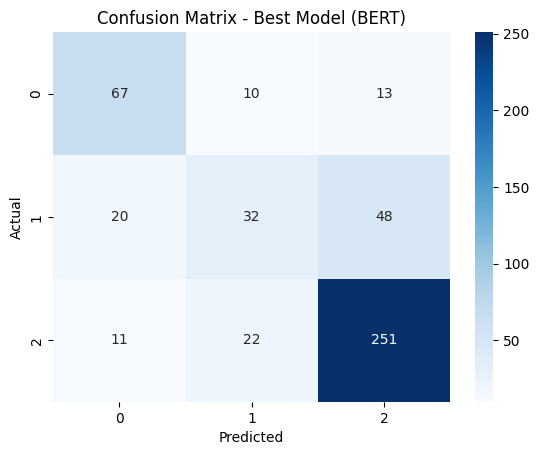

In [46]:
cm = confusion_matrix(y_test, predicted_labels_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title(f'Confusion Matrix - Best Model (BERT)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusions on the final results on the test dataset

- As expected because there was almost no overfit the results obtained were similar to the ones obtained on the validation data, in this case were exactly the same, weighted f1 score of 0.72 and f1 score of 0.74. 
- We can see in the confusion matrix that it is able to predict positive reviews very very well and the same for negative reviews. However it struggles when classifying neutral reviews
- This struggle cold be expected as predicting neutral reviews can be hard because it is hard to define what is neutral, different people can have different opinion. On the other hand a positive or a negative review will almost always show their polarity
- BERT is our best machine learning model, however when comes to sentiment analysis there are also two very good models that are rule based models to predict sentiment. These models are TextBlob and Vader, that we are going to try next but will almost for sure guarantee better results and allow us to get a more in depth understanding about how the text in the reviews really compares to the ratings given by the reviewers (if the ratings are skewed or not).


# Rule Based Approach: Vader and Text Blob

To be done later

Delete the cells below if needed

Logistic Regression Model:

              precision    recall  f1-score   support

    negative       0.65      0.44      0.53        90
     neutral       0.25      0.03      0.05       100
    positive       0.69      0.97      0.80       284

    accuracy                           0.67       474
   macro avg       0.53      0.48      0.46       474
weighted avg       0.59      0.67      0.59       474



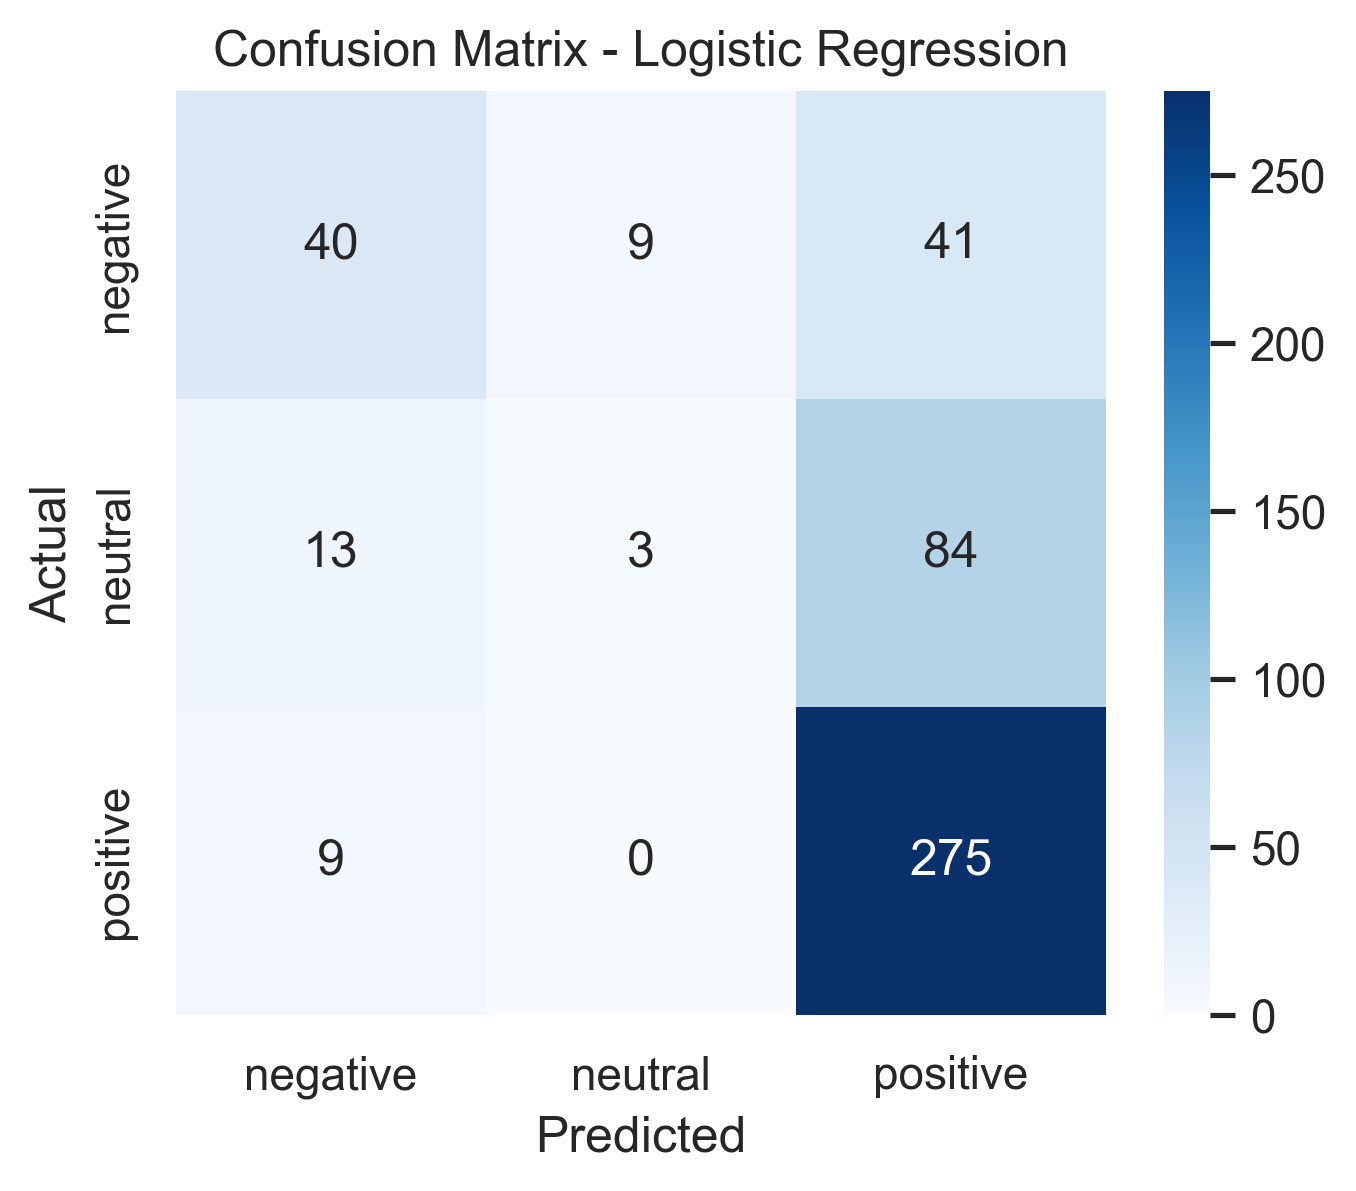

Naive Bayes Model:

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        90
     neutral       0.00      0.00      0.00       100
    positive       0.60      1.00      0.75       284

    accuracy                           0.60       474
   macro avg       0.20      0.33      0.25       474
weighted avg       0.36      0.60      0.45       474



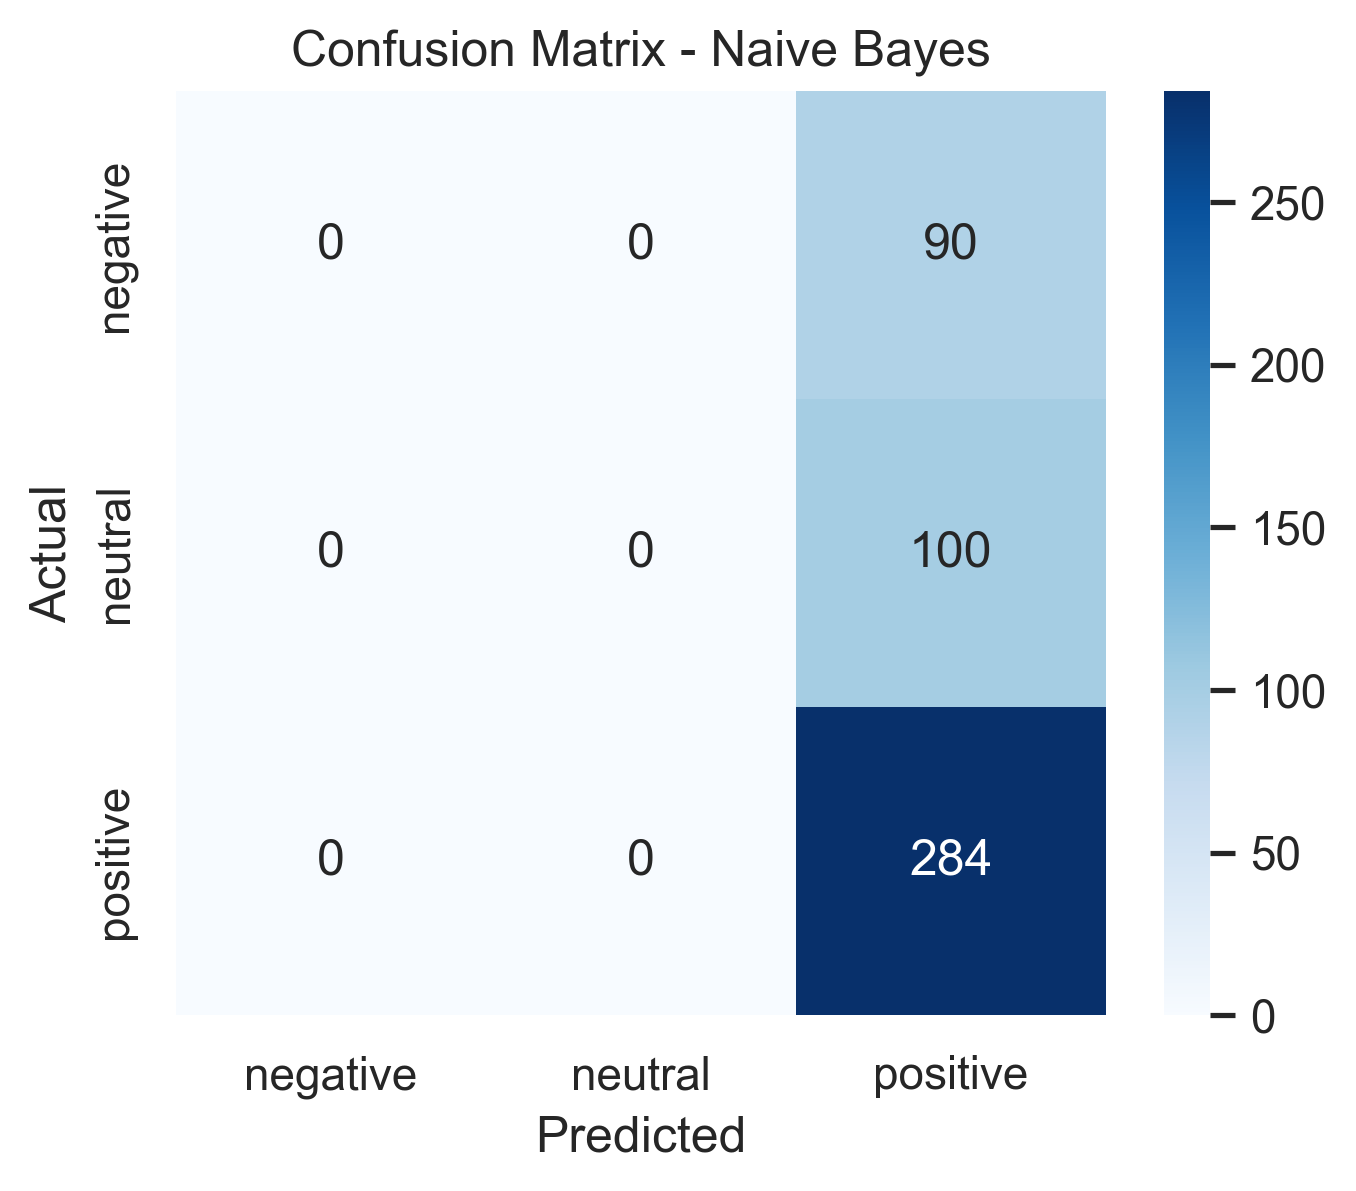

Random Forest Model:

              precision    recall  f1-score   support

    negative       0.74      0.36      0.48        90
     neutral       0.00      0.00      0.00       100
    positive       0.65      0.99      0.79       284

    accuracy                           0.66       474
   macro avg       0.47      0.45      0.42       474
weighted avg       0.53      0.66      0.56       474



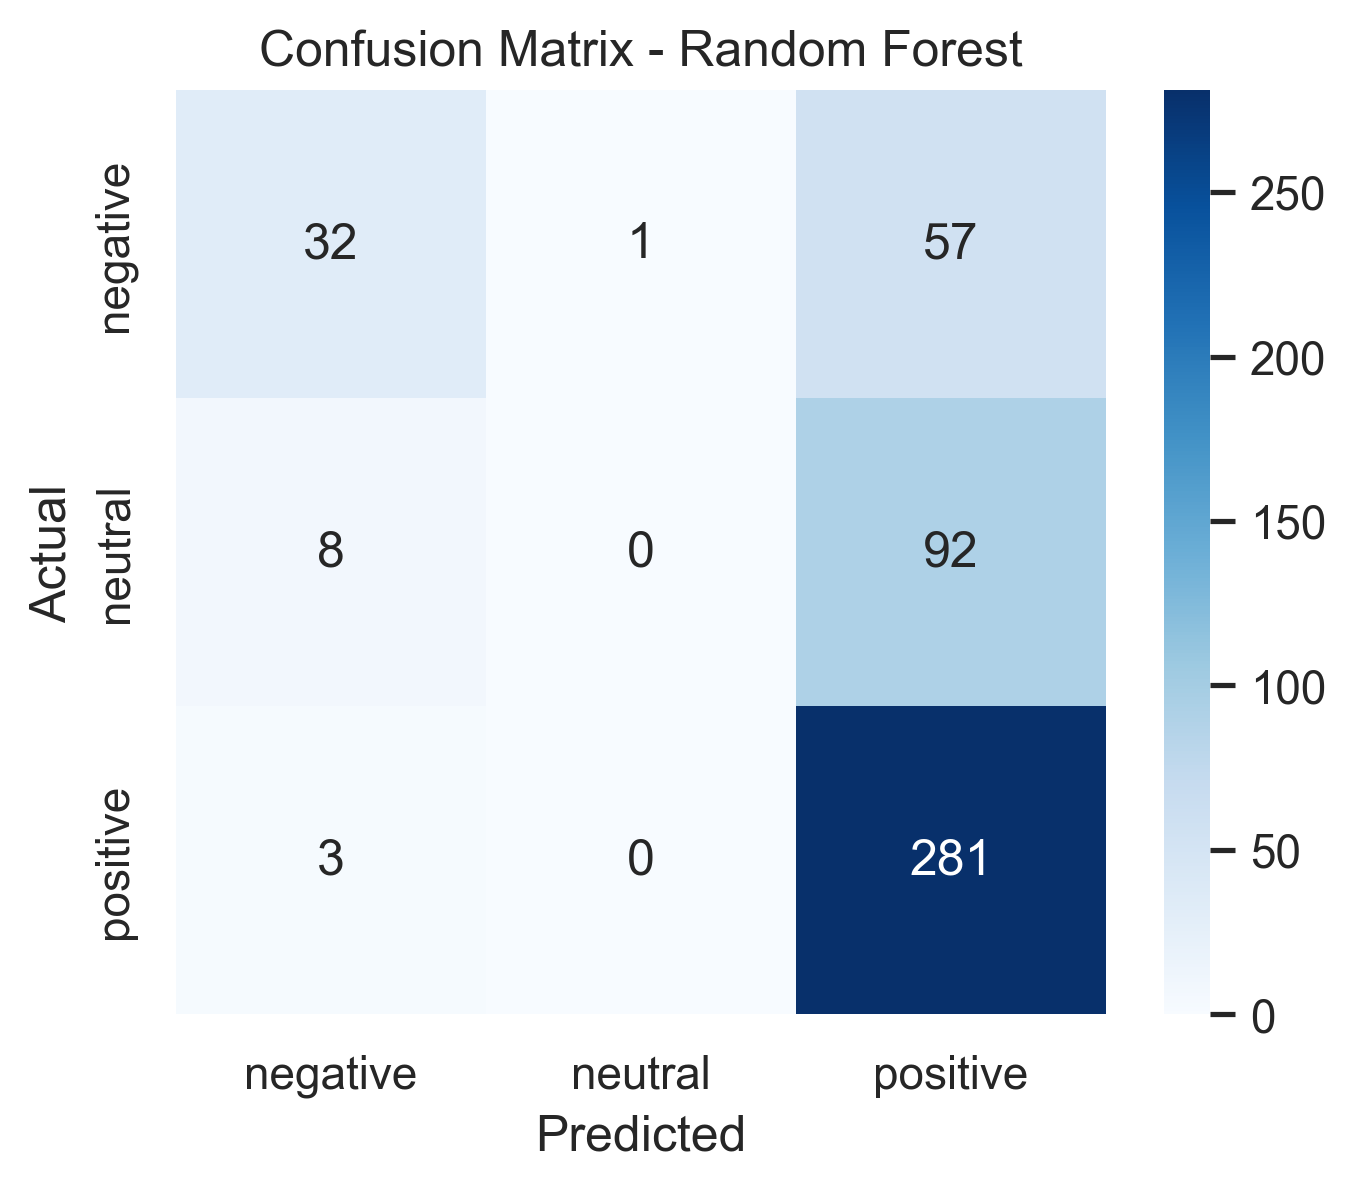

KeyboardInterrupt: 

In [ ]:
# Load Data
data = pd.read_csv("qatar_airways_reviews.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s\'-]', '', text.lower())  # Keep words
    tokens = text.split()
    return ' '.join(tokens)

data['Preprocessed_Reviews'] = data['Review Body'].apply(preprocess_text)
data = data.dropna(subset=['Preprocessed_Reviews'])

def simplify_rating(rating):
    if rating <= 4:
        return 'negative'
    elif rating <= 7:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(simplify_rating)

# Train-Test Split
X = data['Preprocessed_Reviews']
y = data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Model:\n")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return model

# Train Models
lr_model = evaluate_model(LogisticRegression(), X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression")
nb_model = evaluate_model(MultinomialNB(), X_train_tfidf, X_test_tfidf, y_train, y_test, "Naive Bayes")
rf_model = evaluate_model(RandomForestClassifier(), X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest")
svc_model = evaluate_model(SVC(), X_train_tfidf, X_test_tfidf, y_train, y_test, "SVC")

# Hyperparameter tuning for the best model
best_model = SVC()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)
best_svc = grid_search.best_estimator_

print("Best parameters for SVC:", grid_search.best_params_)

y_pred_best = best_svc.predict(X_test_tfidf)
print("\nBest SVC Model:")
print(classification_report(y_test, y_pred_best))

# Final Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=best_svc.classes_, yticklabels=best_svc.classes_)
plt.title('Confusion Matrix - Best Model (SVC)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion
print("\nThe best model based on F1-score is SVC, as it provides better balance between precision and recall across classes compared to Logistic Regression, Naive Bayes, and Random Forest. The hyperparameter tuning further improved its performance by selecting the optimal kernel and regularization parameter.")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the neural network pipeline with scaling
nn_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler adjusted for sparse data
    ('mlp', MLPClassifier(max_iter=500, random_state=42))
])

# Define hyperparameter grid for tuning
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001]
}

# Perform GridSearchCV
nn_grid_search = GridSearchCV(nn_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
nn_grid_search.fit(X_train_tfidf, y_train)

# Get the best model
best_nn_model = nn_grid_search.best_estimator_
y_pred_nn = best_nn_model.predict(X_test_tfidf)

# Print results
print("Best Neural Network Parameters:", nn_grid_search.best_params_)
print("Classification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn))

# Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_nn_model, X_test_tfidf, y_test)
plt.title("Neural Network Confusion Matrix")
plt.show()

# Now compare results with previous models
models = {
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'Random Forest': rf_model,
    'SVM': svc_model,
    'Neural Network': best_nn_model
}

scores = {}
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    scores[name] = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']

# Plot comparison
plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Model Performance Comparison")
plt.show()

# Determine best model
best_model = max(scores, key=scores.get)
print(f"Best performing model: {best_model} with F1 Score: {scores[best_model]:.4f}")
